In [1]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
data = yf.download(' aapl ',period="5y",interval="1D")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)


data=pd.DataFrame(data["close"])


[*********************100%%**********************]  1 of 1 completed


In [3]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(-1,1))
df1=pd.DataFrame(scalar.fit_transform(data),index=data.index.tolist())
df1=df1.rename({0:"close"},axis=1)

df1

,close
2018-09-21,-0.765479
2018-09-24,-0.755753
2018-09-25,-0.751402
2018-09-26,-0.756902
2018-09-27,-0.742826
...,...
2023-09-14,0.742577
2023-09-15,0.733503
2023-09-18,0.770296
2023-09-19,0.783969


In [4]:
split_index=int(len(df1)*0.8)

In [5]:
train=df1.iloc[:split_index,:]
test=df1.iloc[split_index:,:]

In [6]:
tes_model = ExponentialSmoothing(train,
   trend="add",
   seasonal="add",
   seasonal_periods=250
   ).fit(
   )

/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [7]:
test["close_pred"] = tes_model.forecast(len(test)).values

/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_174917/1387657822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["close_pred"] = tes_model.forecast(len(test)).values


In [8]:
test

,close,close_pred
2022-09-20,0.508398,0.483919
2022-09-21,0.468871,0.504990
2022-09-22,0.456690,0.515868
2022-09-23,0.427977,0.506328
2022-09-26,0.432203,0.499367
...,...,...
2023-09-14,0.742577,0.792558
2023-09-15,0.733503,0.786126
2023-09-18,0.770296,0.787377
2023-09-19,0.783969,0.797234


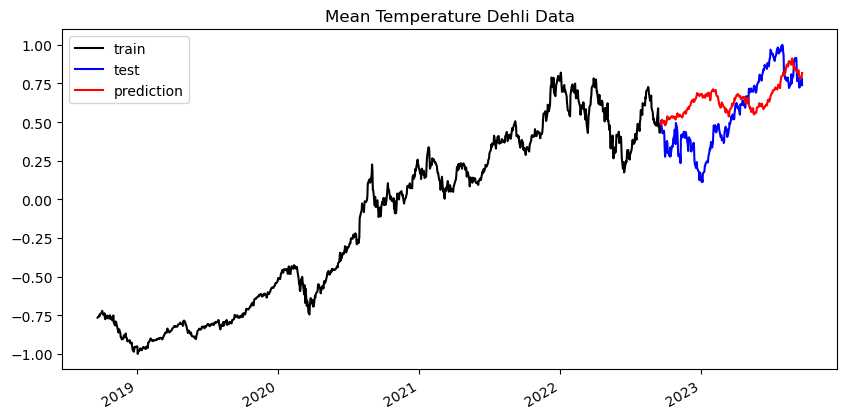

In [9]:

train['close'].plot(style='k', figsize=(10,5), label = 'train')
test['close'].plot(style='b', figsize=(10,5), label = 'test')
test['close_pred'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('Mean Temperature Dehli Data')
plt.legend()

In [10]:
def tes_optimizer(train, test, abg, trend_mode='add', seasonal_mode = 'add'):
    """
        This function to optimize hyperparameters for the TES model
    """
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf") 
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=len(test)).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(len(test))
        mae = mean_absolute_error(test["close"], y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])
        print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))
        return best_alpha, best_beta, best_gamma, best_mae

In [11]:
alphas = betas = gammas = np.arange(0.0010, 1, 0.0020)
abg = list(itertools.product(alphas, betas, gammas))

In [12]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train,test, abg)

/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[0.0, 0.0, 0.0, 0.48]
best_alpha: 0.0 best_beta: 0.0 best_gamma: 0.0 best_mae: 0.48


/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [13]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=len(test)).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
test["close_pred"] = tes_model.forecast(len(test)).values

/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/batuhan-saylam/miniconda3/envs/tf/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_174917/1387657822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["close_pred"] = tes_model.forecast(len(test)).values


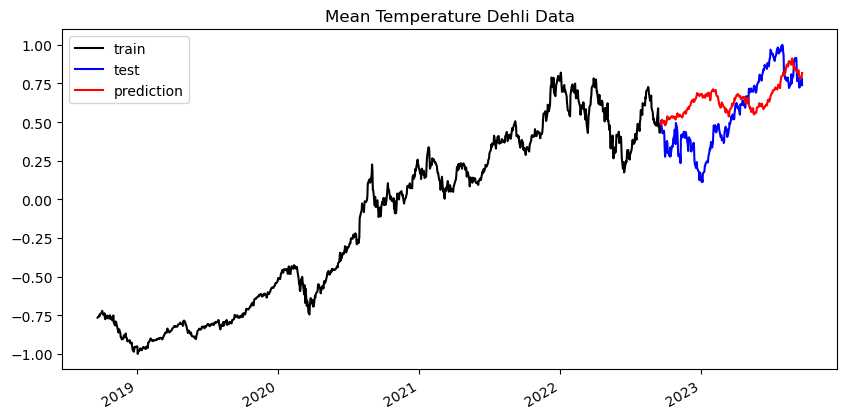

In [15]:

train['close'].plot(style='k', figsize=(10,5), label = 'train')
test['close'].plot(style='b', figsize=(10,5), label = 'test')
test['close_pred'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('Mean Temperature Dehli Data')
plt.legend()